<a href="https://colab.research.google.com/github/AttiBae/BasicML/blob/main/Chapter6_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import tqdm.notebook as tq
import os

In [2]:
## Brain Tumor Data Download

# os.chdir('/content/drive/MyDrive/BasicML/Chapter6')
# os.mkdir('/content/drive/MyDrive/BasicML/Chapter6/brain_tumor')
# os.chdir('./brain_tumor')
## https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection ##
# !kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/BasicML/Chapter6/brain_tumor.zip", 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/BasicML/Chapter6/brain_tumor/')

In [3]:
from glob import glob
path = '/content/drive/MyDrive/BasicML/Chapter6/brain_tumor/'
files = glob(os.path.join(path, '*/*/*'))

print(f'Total # of images {len(files)}')

Total # of images 253


In [4]:
train_num = 200
test_num = int(len(files)  - train_num)
image_shape = (3,128,128)

In [5]:
images_transform = transforms.Compose([transforms.Resize((128,128)),
                                      transforms.ToTensor()])
                                      # transforms.Normalize(mean_images*255, std_images*255)])

images = datasets.ImageFolder(path +'brain_tumor_dataset', images_transform)
train_images, test_images = random_split(images, (train_num, test_num))

In [6]:
train_loader = DataLoader(train_images, batch_size=8) ## Every Data Loader has [image, label]...
test_loader = DataLoader(test_images, batch_size=8) ## Label : Tumor exist >> 1, if not 0

dataloaders = [train_loader, test_loader]

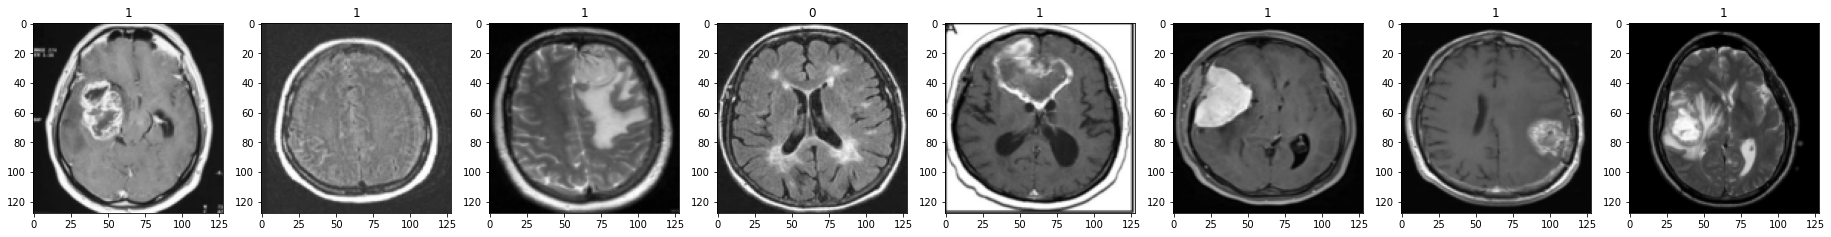

In [8]:
image, label = next(iter(train_loader))
plt.figure(figsize = (32,32))
for i in range(8):
  plt.subplot(1,8,i+1)
  plt.imshow(image[i].permute(1,2,0))
  plt.title(label[i].numpy())
plt.show()

In [9]:
BN_EPS = 1e-4

class ConvBnRelu2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), padding=1):
        super(ConvBnRelu2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, eps=BN_EPS)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class StackEncoder(nn.Module):
    def __init__(self, x_channels, y_channels, kernel_size=(3, 3)):
        super(StackEncoder, self).__init__()
        padding = (kernel_size - 1) // 2
        self.encode = nn.Sequential(
            ConvBnRelu2d(x_channels, y_channels, kernel_size=kernel_size, padding=padding),
            ConvBnRelu2d(y_channels, y_channels, kernel_size=kernel_size, padding=padding),
        )

    def forward(self, x):
        x = self.encode(x)
        x_small = F.max_pool2d(x, kernel_size=2, stride=2)
        return x, x_small


class StackDecoder(nn.Module):
    def __init__(self, x_big_channels, x_channels, y_channels, kernel_size=3):
        super(StackDecoder, self).__init__()
        padding = (kernel_size - 1) // 2

        self.decode = nn.Sequential(
            ConvBnRelu2d(x_big_channels + x_channels, y_channels, kernel_size=kernel_size, padding=padding),
            ConvBnRelu2d(y_channels, y_channels, kernel_size=kernel_size, padding=padding),
            ConvBnRelu2d(y_channels, y_channels, kernel_size=kernel_size, padding=padding),
        )

    def forward(self, x, down_tensor):
        _, channels, height, width = down_tensor.size()
        x = F.interpolate(x, size=(height, width), mode = 'bilinear', align_corners=False)
        x = torch.cat([x, down_tensor], 1)
        x = self.decode(x)
        return x
    
class UNet(nn.Module):
    def __init__(self, in_shape, output_class, filters):
        super(UNet, self).__init__()
        self.channels, self.height, self.width = in_shape

        self.down1 = StackEncoder(self.channels, filters, kernel_size=3) ## 32
        self.down2 = StackEncoder(filters, filters*2, kernel_size=3) ## 64
        self.down3 = StackEncoder(filters*2, filters*2*2, kernel_size=3) ## 128
        self.down4 = StackEncoder(filters*2*2, filters*2*2*2, kernel_size=3) ## 256

        self.up4 = StackDecoder(filters*2*2*2, filters*2*2*2, filters*2*2, kernel_size=3) ## 256
        self.up3 = StackDecoder(filters*2*2, filters*2*2, filters*2, kernel_size=3) ## 128
        self.up2 = StackDecoder(filters*2, filters*2, filters, kernel_size=3) ## 64
        self.up1 = StackDecoder(filters, filters, filters, kernel_size=3) ## 32
        self.classify = nn.Conv2d(filters, 1, kernel_size=1, bias=True) ## output channel 1 -> x == [batch, 1, height, width]

        self.center = nn.Sequential(ConvBnRelu2d(filters*2*2*2, filters*2*2*2, kernel_size=3, padding=1))

        self.conv1d = nn.Conv1d(self.height*self.width, output_class, kernel_size = 1, bias = True) ## 1D Convolution for viewd data : x == [batch, height*width] -> x == [batch, 1]
        

    def forward(self, x):
        out = x; 
        down1, out = self.down1(out); 
        down2, out = self.down2(out); 
        down3, out = self.down3(out); 
        down4, out = self.down4(out);

        out = self.center(out)
        out = self.up4(out, down4); 
        out = self.up3(out, down3); 
        out = self.up2(out, down2); 
        out = self.up1(out, down1); 
        out = self.classify(out);
        out = out.view(-1, self.height*self.width).unsqueeze(2) ## x == [batch, height*width]
        out = self.conv1d(out) ## x == [batch, 1]
        out = torch.squeeze(out, dim=1);
        return out

In [10]:
model = UNet(image_shape, output_class = 2, filters = 32)
## 32 > 64 > 128 > 256 >128 > 64 > 32 > 2

if torch.cuda.is_available():
  device = torch.device('cuda')
  model = model.to(device)
  is_cuda = 1
else: is_cuda = 0

In [11]:
learning_rate = 0.00003
criterion = nn.CrossEntropyLoss() ## Binary Categorization ( Yes[1] or No[0] )
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

num_epochs = 10

data_num = [train_num,test_num]

In [12]:
start = time.time()
best_model = model.state_dict()
best_acc = 0.0
print("Model : Brain Tumor - Unet")

for epochs in tq.trange(num_epochs, desc=f"Total {num_epochs} Epochs", leave=False):
  print('------------------------------------------')
  print('Epochs #{}'.format(epochs))
  for mode in ['train', 'test']:
    epoch_loss = 0.0
    epoch_acc = 0.0
    if mode == 'train':
      model.train(True)
      flag = 0
    else:
      model.train(False)
      flag = 1

    running_loss = 0.0  ## Loss & Acc Initialize
    running_corrects = 0.0

    for data in dataloaders[flag]:  ## Read Data from dataloaders
      (images, labels) = data
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()  ## Optimizer initialize every batch
      outputs = model(images)  ## Put images to network
      pred = torch.max(outputs.data, 1, keepdim=True)[1]  ## prediction
      loss = criterion(outputs.squeeze(2), labels)

      if mode == 'train':
        loss.backward()
        optimizer.step()  ## optimizer task for train

      running_loss += loss.item()
      running_corrects += pred.eq(labels.data.view_as(pred)).sum()
    epoch_loss = running_loss / train_num
    epoch_acc = running_corrects / data_num[flag] * 100  ## Accuracy (0~100%)
    print('{}\tLoss : {:.5} Acc : {:.3f}'.format(mode, epoch_loss, epoch_acc))
elapsed_time = time.time() - start
print('Elapsed time : {}s'.format(elapsed_time))

Model : Brain Tumor - Unet


------------------------------------------
Epochs #0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train	Loss : 0.078579 Acc : 66.000
test	Loss : 0.023547 Acc : 64.151
------------------------------------------
Epochs #1
train	Loss : 0.036328 Acc : 93.500
test	Loss : 0.019239 Acc : 83.019
------------------------------------------
Epochs #2
train	Loss : 0.012184 Acc : 100.000
test	Loss : 0.015377 Acc : 75.472
------------------------------------------
Epochs #3
train	Loss : 0.0033413 Acc : 100.000
test	Loss : 0.016648 Acc : 84.906
------------------------------------------
Epochs #4
train	Loss : 0.0015156 Acc : 100.000
test	Loss : 0.018559 Acc : 83.019
------------------------------------------
Epochs #5
train	Loss : 0.0011655 Acc : 100.000
test	Loss : 0.019247 Acc : 83.019
------------------------------------------
Epochs #6
train	Loss : 0.00059209 Acc : 100.000
test	Loss : 0.019444 Acc : 83.019
------------------------------------------
Epochs #7
train	Loss : 0.00024338 Acc : 100.000
test	Loss : 0.019908 Acc : 84.906
------------------------------------------
Epochs #8
train	Loss 

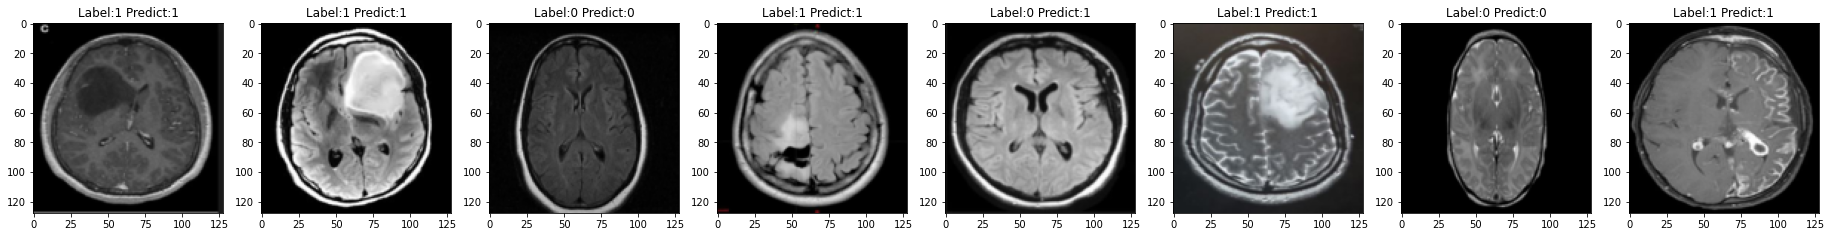

In [13]:
image, label = next(iter(test_loader))
image = image.to(device)
outputs = model(image)
pred = torch.max(outputs.data, 1, keepdim=True)[1].squeeze(1)
image_img = image.cpu()

plt.figure(figsize = (32,32))
for i in range(8):
  plt.subplot(1,8,i+1)
  plt.imshow(image_img[i].permute(1,2,0))
  plt.title("Label:{} Predict:{}".format(label[i], pred.squeeze(1)[i]))
plt.show()